In [118]:
from IPython.display import display, clear_output
import matplotlib.patches as patches
from IPython.display import display
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import ipywidgets as widgets
import tensorflow as tf
import numpy as np
import cv2
import os

In [10]:
# Function to create an XML file for image annotation
def create_annotation_xml(filename, folder, width, height, depth, segmented, object_list):
    # Create the file structure
    annotation = ET.Element('annotation')
    ET.SubElement(annotation, 'folder').text = folder
    ET.SubElement(annotation, 'filename').text = filename
    size = ET.SubElement(annotation, 'size')
    ET.SubElement(size, 'width').text = str(width)
    ET.SubElement(size, 'height').text = str(height)
    ET.SubElement(size, 'depth').text = str(depth)
    ET.SubElement(annotation, 'segmented').text = str(segmented)

    for obj in object_list:
        object_tag = ET.SubElement(annotation, 'object')
        ET.SubElement(object_tag, 'name').text = obj['name']
        ET.SubElement(object_tag, 'pose').text = obj['pose']
        ET.SubElement(object_tag, 'truncated').text = str(obj['truncated'])
        ET.SubElement(object_tag, 'occluded').text = str(obj['occluded'])
        ET.SubElement(object_tag, 'difficult').text = str(obj['difficult'])
        bndbox = ET.SubElement(object_tag, 'bndbox')
        ET.SubElement(bndbox, 'xmin').text = str(obj['bndbox']['xmin'])
        ET.SubElement(bndbox, 'ymin').text = str(obj['bndbox']['ymin'])
        ET.SubElement(bndbox, 'xmax').text = str(obj['bndbox']['xmax'])
        ET.SubElement(bndbox, 'ymax').text = str(obj['bndbox']['ymax'])

    # Create a new XML file with the results
    tree = ET.ElementTree(annotation)
    tree.write(r"custom data/annots/annots.xml")

In [54]:
def create_xml(width, height, xmins, ymins, xmaxes, ymaxes, filename, path, folder="images"):
    """
    Create an XML file with multiple bounding boxes.
    
    Parameters:
    - filename: The name of the image file.
    - folder: The folder where the image is located.
    - path: The full path to the image file.
    - width, height: The dimensions of the image.
    - xmins, ymins, xmaxes, ymaxes: Lists of coordinates for the bounding boxes.
    """
    # Check if all lists are of the same length
    if not (len(xmins) == len(ymins) == len(xmaxes) == len(ymaxes)):
        raise ValueError("All coordinate lists must have the same length.")

    # Create the file structure
    annotation = ET.Element('annotation')
    ET.SubElement(annotation, 'folder').text = folder
    ET.SubElement(annotation, 'filename').text = f"{filename}.png"
    ET.SubElement(annotation, 'path').text = path
    source = ET.SubElement(annotation, 'source')
    ET.SubElement(source, 'database').text = 'Unknown'
    size = ET.SubElement(annotation, 'size')
    ET.SubElement(size, 'width').text = str(width)
    ET.SubElement(size, 'height').text = str(height)
    ET.SubElement(size, 'depth').text = "3"
    ET.SubElement(annotation, 'segmented').text = '0'

    # Add objects with bounding boxes
    for xmin, ymin, xmax, ymax in zip(xmins, ymins, xmaxes, ymaxes):
        object_tag = ET.SubElement(annotation, 'object')
        ET.SubElement(object_tag, 'name').text = 'licence'
        ET.SubElement(object_tag, 'pose').text = 'Unspecified'
        ET.SubElement(object_tag, 'truncated').text = '0'
        ET.SubElement(object_tag, 'difficult').text = '0'
        bndbox = ET.SubElement(object_tag, 'bndbox')
        ET.SubElement(bndbox, 'xmin').text = str(xmin)
        ET.SubElement(bndbox, 'ymin').text = str(ymin)
        ET.SubElement(bndbox, 'xmax').text = str(xmax)
        ET.SubElement(bndbox, 'ymax').text = str(ymax)

    # # Create a new XML file with the results
    tree = ET.ElementTree(annotation)
    xml_output_path = f'custom data//annots//{filename}.xml'
    tree.write(xml_output_path)
    return xml_output_path

In [52]:
def preprocess_image(frame):

    orig_h, orig_w = frame.shape[:2]
    frame = cv2.resize(frame, (320, 320))  # Resize to match model's input size
    frame = np.expand_dims(frame, axis=0)  # Add batch dimension
    return frame, orig_h, orig_w

In [19]:
model = tf.saved_model.load(r"../mobilenet_320_exported/saved_model")

In [124]:
cap = cv2.VideoCapture(r"custom data/Tel Aviv, Israel - Driving Tour 4K.mp4")
cap.set(cv2.CAP_PROP_POS_FRAMES, 1000)
total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

xmins = []
ymins = []
xmaxes = []
ymaxes = []
found_frames = []
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
frame = None

def preprocess_image(frame):
    orig_h, orig_w = frame.shape[:2]
    frame = cv2.resize(frame, (320, 320))  # Resize to match model's input size
    frame = np.expand_dims(frame, axis=0)  # Add batch dimension
    return frame, orig_h, orig_w


def display_next_frame(forward=True):
    current_frame_number = cap.get(cv2.CAP_PROP_POS_FRAMES) + 19
    global xmins, ymins, xmaxes, ymaxes, frame, found_frames
    if forward:
        cap.set(cv2.CAP_PROP_POS_FRAMES, current_frame_number)
    else:
        found_frames.pop()
        cap.set(cv2.CAP_PROP_POS_FRAMES, found_frames[-1])
        found_frames.pop()
    ret, frame = cap.read()
    frame_cop = frame.copy()
    if not ret:
        print("Finished processing or error.")
        cap.release()
        return

    mod_frame, orig_h, orig_w = preprocess_image(frame_cop)

    predictions = model(mod_frame)
    
    # Assuming predictions contain boxes, classes, and scores
    boxes = predictions['detection_boxes'][0].numpy()
    scores = predictions['detection_scores'][0].numpy()
    
    _, h, w, _ = mod_frame.shape
    xmins = []
    ymins = []
    xmaxes = []
    ymaxes = []
    plates = []
    for i in range(len(scores)):
        if scores[i] > 0.15:  # Only consider detections with high confidence
            box = boxes[i]
            
            # Scale the bounding box coordinates up to the original image size
            startY, startX, endY, endX = box
            startX, startY, endX, endY = (startX * orig_w, startY * orig_h, endX * orig_w, endY * orig_h)
            startX, startY, endX, endY = int(startX), int(startY), int(endX), int(endY)
            xmins.append(startX)
            ymins.append(startY)
            xmaxes.append(endX)
            ymaxes.append(endY)
            plates.append(frame[startY:endY, startX:endX].copy())
            cv2.rectangle(frame_cop, (startX, startY), (endX, endY), (0, 255, 0), 2)
    if not plates:
        display_next_frame()
    else:
        print(f"{int(current_frame_number)}/{total_frames}")
        found_frames.append(int(current_frame_number))
        plt.imshow(cv2.cvtColor(frame_cop, cv2.COLOR_BGR2RGB))
        plt.show()


button_next = widgets.Button(description="Next")
button_save = widgets.Button(description="Save")
button_prev = widgets.Button(description="Previous")
button_choose = widgets.Button(description="Choose plate")
output = widgets.Output()

# Define button click action
def on_next_clicked(b):
    with output:
        clear_output(wait=True)
        display_next_frame()


def on_prev_clicked(b):
    with output:
        clear_output(wait=True)
        display_next_frame(False)


def on_save_clicked(b):
    with output:
        clear_output(wait=True)

        # Save####
        i = 0
        file_path = f"custom data//images//image{i}.png"
        while os.path.exists(file_path):  # Find next file name
            i+=1
            file_path = f"custom data//images//image{i}.png"
            continue
        print(f"Saved as image{i}")
        cv2.imwrite(file_path, frame) 
        file_name = f"image{i}"
        create_xml(width, height, xmins, ymins, xmaxes, ymaxes, file_name, f"E://Coding//License-plate-deep-learning//Pretrained 2//Dataset//Images_from_video//{file_name}.png")
        ###
        display_next_frame()


def on_choose_clicked(b):
    with output:
        frame_cop = frame.copy()
        clear_output(wait=True)
        for xmin, ymin, xmax, ymax in zip(xmins, ymins, xmaxes, ymaxes):
            cv2.rectangle(frame_cop, (startX, startY), (endX, endY), (0, 255, 0), 2)
        

button_next.on_click(on_next_clicked)
button_save.on_click(on_save_clicked)
button_prev.on_click(on_prev_clicked)
button_choose.on_click(on_choose_clicked)

# Display the button and the output container
buttons = widgets.HBox([button_prev, button_save, button_next])

display(buttons, output)

# Start by displaying the first frame
# display_frame()

Output()

[0.7635254  0.39681786 0.77448374 0.40764463]


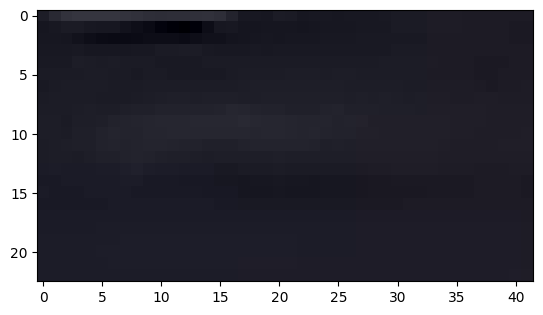

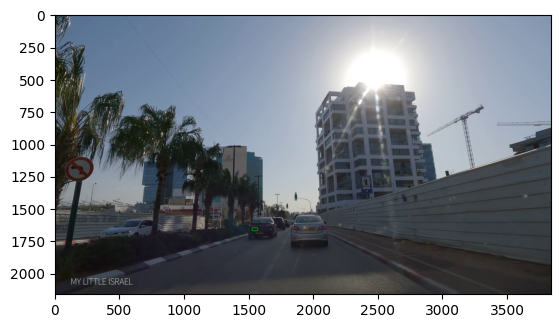

In [67]:
cap = cv2.VideoCapture(r"custom data/Tel Aviv, Israel - Driving Tour 4K.mp4")
count = 0 
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    # if count < 1000:
        # count += 1
        # continue
    frame = cv2.imread(r"../../Pretrained/Dataset/Images_from_video/Image212.png")
    mod_frame, orig_h, orig_w = preprocess_image(frame)

    predictions = model(mod_frame)
    
    # Assuming predictions contain boxes, classes, and scores
    boxes = predictions['detection_boxes'][0].numpy()
    scores = predictions['detection_scores'][0].numpy()
    
    _, h, w, _ = mod_frame.shape
    xmins = []
    ymins = []
    xmaxes = []
    ymaxes = []
    plates = []
    for i in range(len(scores)):
        if scores[i] > 0.15:  # Only consider detections with high confidence
            box = boxes[i]
            print(box)
            
            # Scale the bounding box coordinates up to the original image size
            startY, startX, endY, endX = box
            startX, startY, endX, endY = (startX * orig_w, startY * orig_h, endX * orig_w, endY * orig_h)
            startX, startY, endX, endY = int(startX), int(startY), int(endX), int(endY)
            xmins.append(startX)
            ymins.append(startY)
            xmaxes.append(endX)
            ymaxes.append(endY)
            plates.append(frame[startY:endY, startX:endX].copy())
            cv2.rectangle(frame, (startX, startY), (endX, endY), (0, 255, 0), 2)
    if not plates:
        continue
    # Check if it's actually correct
    for plate in plates:
        plt.imshow(cv2.cvtColor(plate, cv2.COLOR_BGR2RGB))
        plt.show()
        
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    break
    i = 0
    file_path = f"custom data//images//image{i}.png"
    while os.path.exists(file_path):  # Find next file name
        i+=1
        file_path = f"custom data//images//image{i}.png"
        continue
    cv2.imwrite(file_path, frame) 
    file_name = f"image{i}"
    create_xml(orig_w, orig_h, xmins, ymins, xmaxes, ymaxes, file_name, f"E://Coding//License-plate-deep-learning//Pretrained 2//Dataset//Images_from_video//{file_name}.png")
    

        
    # if not plates:
    #     continue
    # plt.imshow(cv2.cvtColor(plates[0], cv2.COLOR_BGR2RGB))
    plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    plt.show()
    break


In [7]:
# Example usage of the function
# Define the object list with bounding box details
object_list = [{
    'name': 'licence',
    'pose': 'Unspecified',
    'truncated': 0,
    'occluded': 0,
    'difficult': 0,
    'bndbox': {
        'xmin': 146,
        'ymin': 187,
        'xmax': 260,
        'ymax': 210  # Assuming a value here for demonstration purposes
    }
}]

# Create XML file
create_annotation_xml('Cars53.png', 'images', 400, 288, 3, 0, object_list)

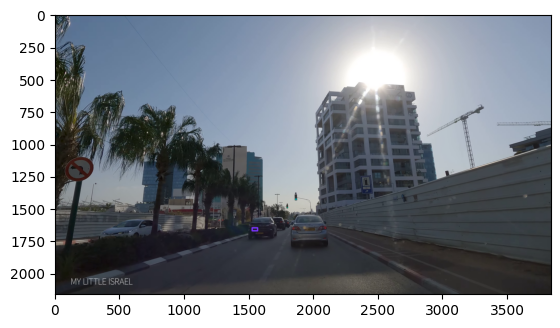

In [59]:
def test():
    img = cv2.imread("D:\Coding\License-plate-deep-learning\Pretrained\Dataset\Images_from_video\Image212.png")
    # cv2.rectangle(img, (1917, 1649), (2005, 1675), (255, 52, 123), 10)
    cv2.rectangle(img, (1523, 1649), (1565, 1672), (255, 52, 123), 10)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

test()

In [71]:
import ipywidgets as widgets
from IPython.display import display

# Define the functions for each button
def on_button_one_clicked(b):
    print("Button one clicked!")

def on_button_two_clicked(b):
    print("Button two clicked!")

# Create two buttons
button_one = widgets.Button(description="Click Me One")
button_two = widgets.Button(description="Click Me Two")

# Display the buttons
display(button_one, button_two)

# Attach the functions to the buttons
button_one.on_click(on_button_one_clicked)
button_two.on_click(on_button_two_clicked)

Button(description='Click Me One', style=ButtonStyle())

Button(description='Click Me Two', style=ButtonStyle())

In [ ]:
import ipywidgets as widgets

clicked = False
# This function will be executed when the button is clicked
def on_button_clicked(b):
    # The code you want to execute on button click
    print("Button has been clicked!")
    clicked = True

while not clicked:
    button = widgets.Button(description="Click Me")
    button.on_click(on_button_clicked)  # Link the click event to the function
    display(button)


Button(description='Next Frame', style=ButtonStyle())

Output()